#Imports

In [30]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from typing import Callable, Tuple, Dict, List
import time

#Data Loading

In [31]:
def load_mnist_full(flatten: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    # Fetch MNIST via Keras without train/test split.
    from tensorflow.keras.datasets import mnist  # Lazy import

    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Concatenate train and test to form full dataset
    X_full = np.concatenate((X_train, X_test), axis=0)
    y_full = np.concatenate((y_train, y_test), axis=0)

    if flatten:
        X_full = X_full.reshape(-1, 28 * 28).astype(np.float32)

    return X_full, y_full

#Distance Functions

In [32]:
def l2(a: np.ndarray, b: np.ndarray) -> float:
    """Euclidean distance."""
    return np.linalg.norm(a - b)

def l1(a: np.ndarray, b: np.ndarray) -> float:
    """Manhattan distance."""
    return np.abs(a - b).sum()

def cosine(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine distance (1 − cos θ)."""
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return 1.0 - (np.dot(a, b) / denom if denom else 0.0)

_DISTANCE_FUNCS: Dict[str, Callable[[np.ndarray, np.ndarray], float]] = {
    "euclidean": l2,
    "manhattan": l1,
    "cosine": cosine,
}

#K-means Implementation

In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Distance functions vectorized for different metrics
def euclidean_distance(X, centroids):
    # Calculate Euclidean distance between all data points and centroids
    return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

def manhattan_distance(X, centroids):
    # Calculate Manhattan distance between all data points and centroids
    return np.sum(np.abs(X[:, np.newaxis, :] - centroids), axis=2)

def cosine_distance(X, centroids):
    # Calculate Cosine distance between all data points and centroids
    return cosine_distances(X, centroids)

# Dictionary of distance functions
distance_funcs = {'euclidean': euclidean_distance, 'manhattan': manhattan_distance, 'cosine': cosine_distance}

# K means implementation
def kmeans(X, k, distance='euclidean', max_iter=100, tol=1e-4, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    X = X.astype(np.float32)

    # Random initialization of centroids
    n_samples = X.shape[0]
    centroids = X[rng.choice(n_samples, k, replace=False)].astype(np.float32)

    # Selecting the appropriate distance function
    distance_func = distance_funcs[distance]

    for _ in range(max_iter):
        # Calculate distances between data points and centroids
        distances = distance_func(X, centroids)
        # Assign each data point to the nearest centroid
        assignments = np.argmin(distances, axis=1)

        # Initialize new centroids
        new_centroids = np.empty_like(centroids)
        for j in range(k):
            # Identify all data points assigned to the current centroid
            members = X[assignments == j]
            if len(members) == 0:
                new_centroids[j] = centroids[j]  # If no points assigned, retain the old centroid
                continue
            # Update centroid based on the distance metric
            if distance == "manhattan":
                new_centroids[j] = np.median(members, axis=0)
            else:
                new_centroids[j] = members.mean(axis=0)

            # Normalize for cosine distance
            if distance == "cosine":
                norm = np.linalg.norm(new_centroids[j])
                if norm:
                    new_centroids[j] = new_centroids[j] / norm

        # Calculate centroid shift to check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break

        centroids = new_centroids

    return centroids, assignments


#Cluster Labeling

In [34]:
def label_clusters(assignments: np.ndarray, y_true: np.ndarray, k: int) -> List[int]:
    """Greedy labeling rule for assigning cluster labels based on majority voting."""
    table = np.zeros((k, 10), dtype=int)
    for idx, cluster in enumerate(assignments):
        table[cluster, y_true[idx]] += 1

    labels = [-1] * k
    rows_used, cols_used = set(), set()
    while len(rows_used) < k and len(cols_used) < 10:
        i, j = divmod(table.argmax(), table.shape[1])
        if i not in rows_used and j not in cols_used:
            labels[i] = j
            rows_used.add(i)
            cols_used.add(j)
            table[i, :] = -1  # exclude row/col from further consideration
            table[:, j] = -1
        else:
            table[i, j] = -1  # skip this max

    # Fallback for any unlabeled clusters
    for idx in range(k):
        if labels[idx] == -1:
            labels[idx] = int(table[idx].argmax())
    return labels

#Evaluate Function

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(
    X: np.ndarray,
    y: np.ndarray,
    distance: str,
    n_splits: int = 5,
    rng_seed: int = 42,
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng_seed)
    train_acc, test_acc = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        centroids, train_assign = kmeans(
            X_train, k=10, distance=distance, rng=np.random.default_rng(fold)
        )
        cluster_labels = label_clusters(train_assign, y_train, k=10)

        # Training metrics
        y_train_pred = np.array([cluster_labels[c] for c in train_assign])
        train_acc.append(accuracy_score(y_train, y_train_pred))

        # Test: 1‑NN to nearest centroid
        dist_fn = _DISTANCE_FUNCS[distance]
        test_pred = []
        for x in X_test:
            dists = [dist_fn(x, c) for c in centroids]
            cluster_idx = int(np.argmin(dists))
            test_pred.append(cluster_labels[cluster_idx])
        test_acc.append(accuracy_score(y_test, test_pred))

        # Confusion matrix for this fold - Visualized
        cm = confusion_matrix(y_test, test_pred)
        print(f"[Fold {fold}] train acc={train_acc[-1]:.4f} | test acc={test_acc[-1]:.4f}")
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
        plt.title(f"Confusion Matrix for Fold {fold}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

        # print(f"[Fold {fold}] train acc={train_acc[-1]:.4f} | test acc={test_acc[-1]:.4f}")

    print(f"—— {distance.capitalize()} summary ——")
    print(f"Mean train accuracy: {np.mean(train_acc):.4f} ± {np.std(train_acc):.4f}")
    print(f"Mean test  accuracy: {np.mean(test_acc):.4f} ± {np.std(test_acc):.4f}")

#Test Without PCA

[Fold 1] train acc=0.4397 | test acc=0.4389


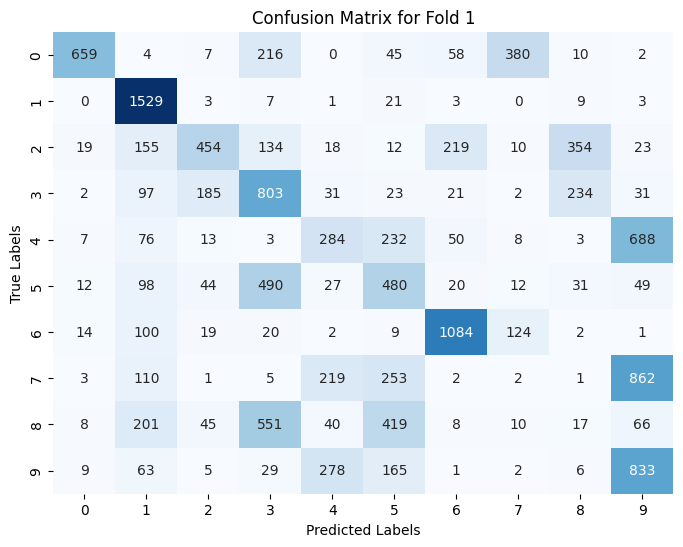

[Fold 2] train acc=0.4502 | test acc=0.4459


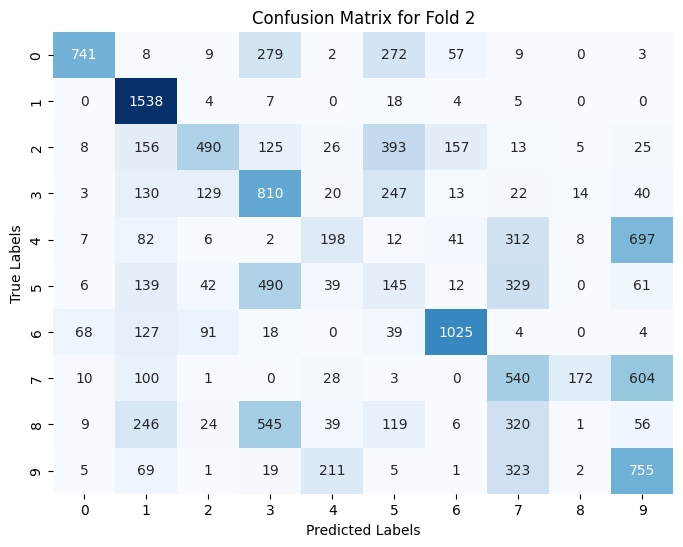

[Fold 3] train acc=0.4883 | test acc=0.4856


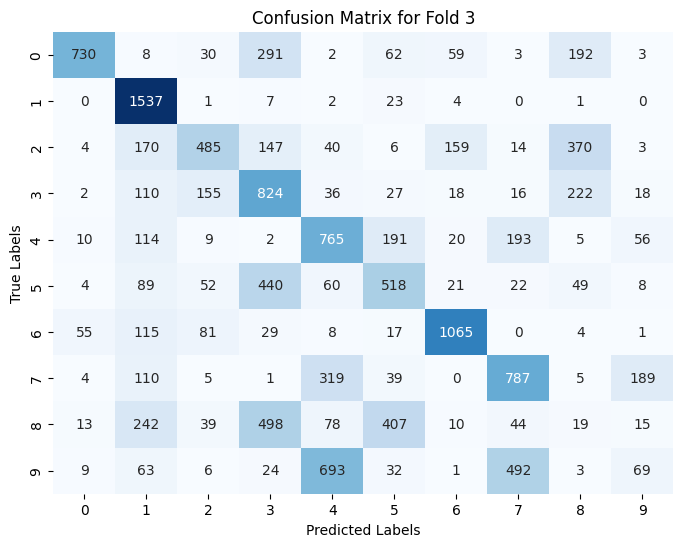

[Fold 4] train acc=0.5000 | test acc=0.5041


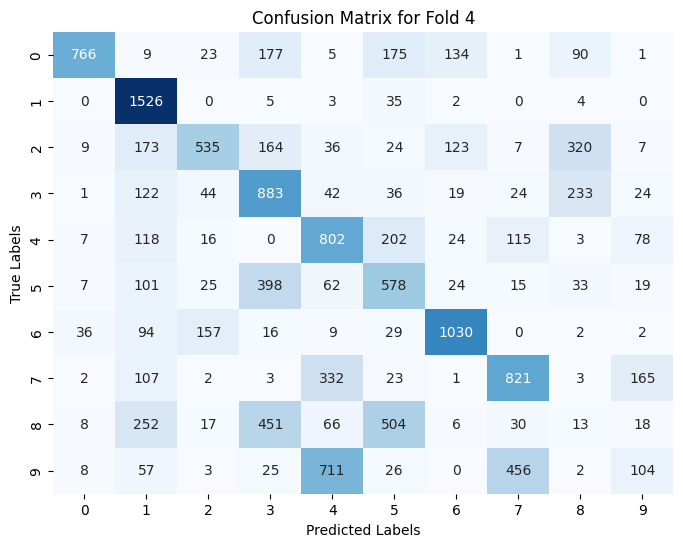

[Fold 5] train acc=0.5072 | test acc=0.5006


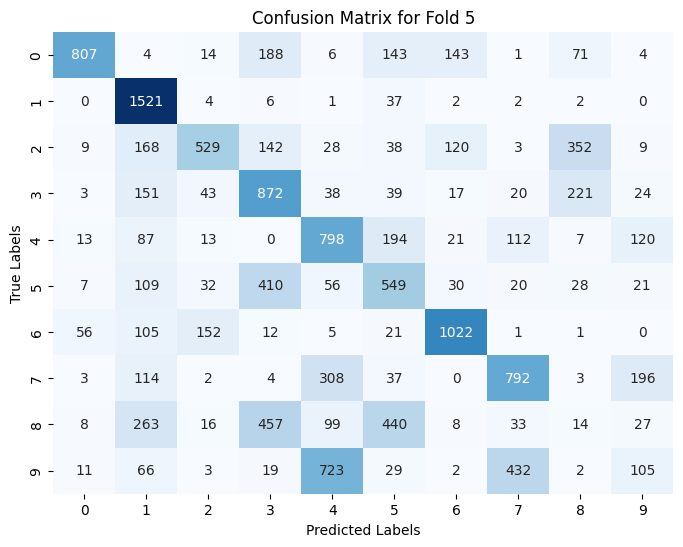

—— Euclidean summary ——
Mean train accuracy: 0.4771 ± 0.0271
Mean test  accuracy: 0.4751 ± 0.0274
Euclidean distance metric completed. time: 657.23 seconds.

[Fold 1] train acc=0.4610 | test acc=0.4638


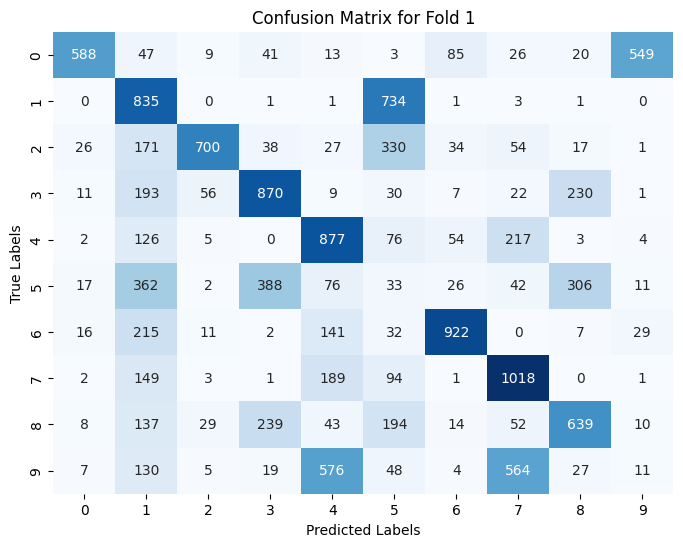

[Fold 2] train acc=0.4744 | test acc=0.4779


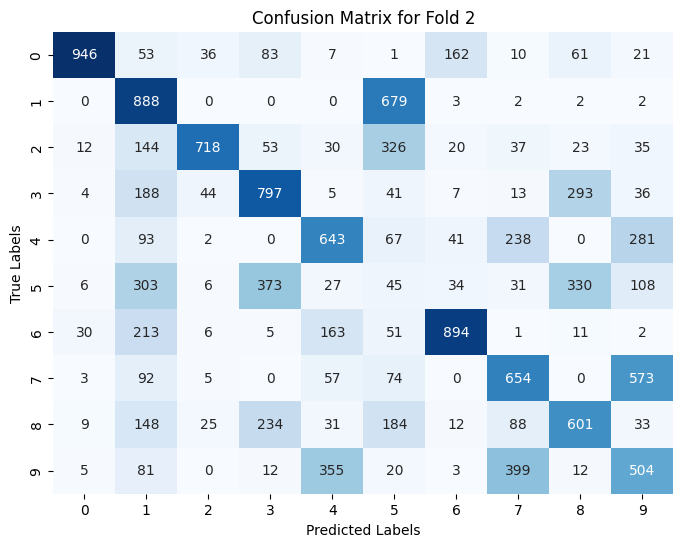

[Fold 3] train acc=0.4650 | test acc=0.4669


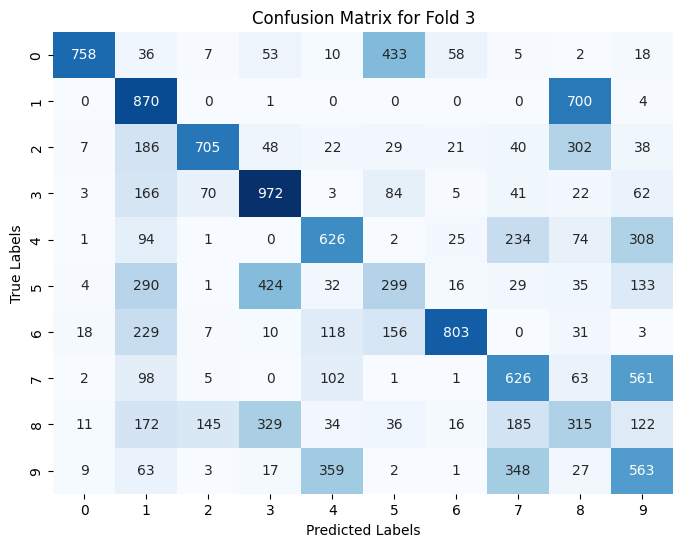

[Fold 4] train acc=0.5247 | test acc=0.5279


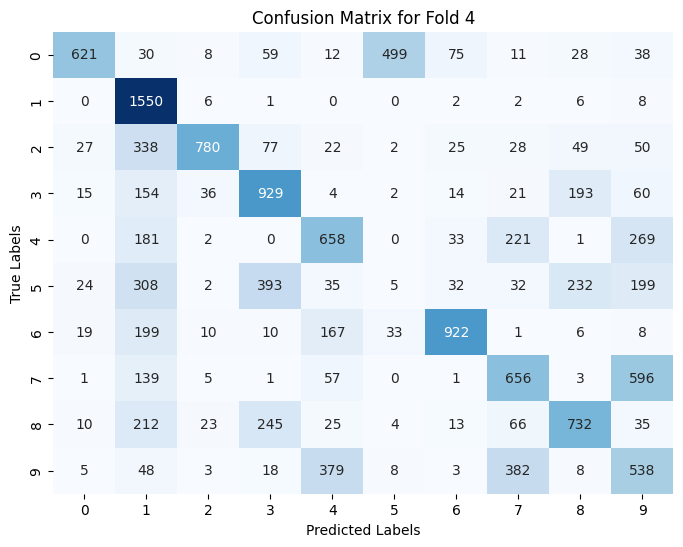

[Fold 5] train acc=0.4788 | test acc=0.4788


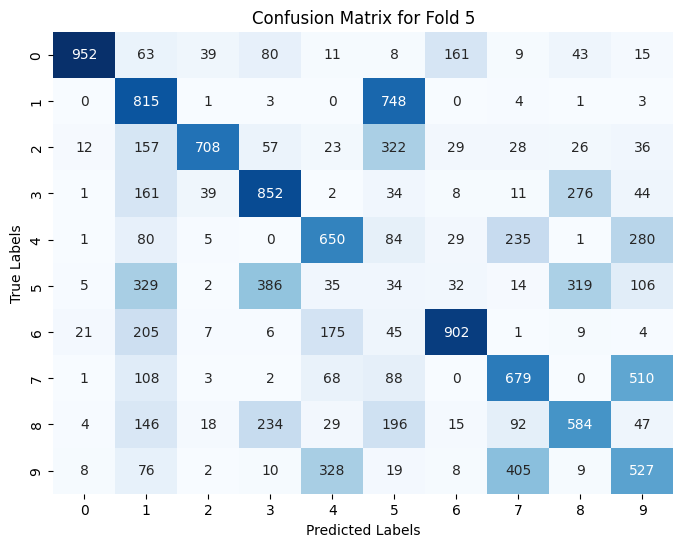

—— Manhattan summary ——
Mean train accuracy: 0.4808 ± 0.0229
Mean test  accuracy: 0.4831 ± 0.0232
Manhattan distance metric completed. time: 1136.54 seconds.

[Fold 1] train acc=0.4898 | test acc=0.4942


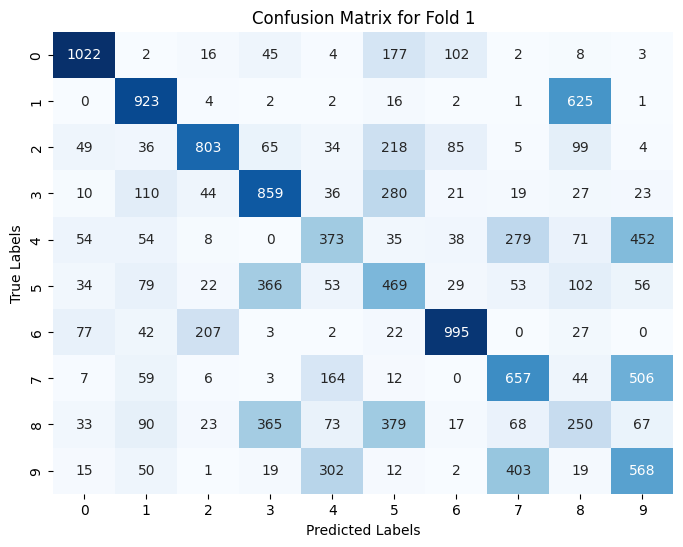

[Fold 2] train acc=0.5249 | test acc=0.5201


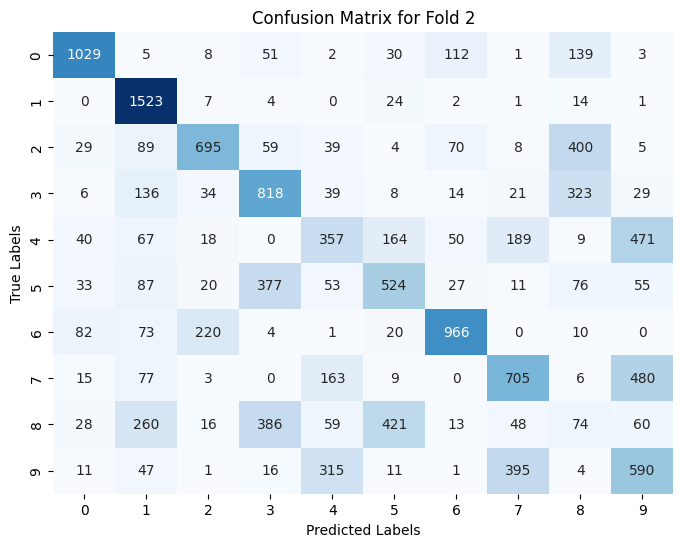

[Fold 3] train acc=0.5243 | test acc=0.5224


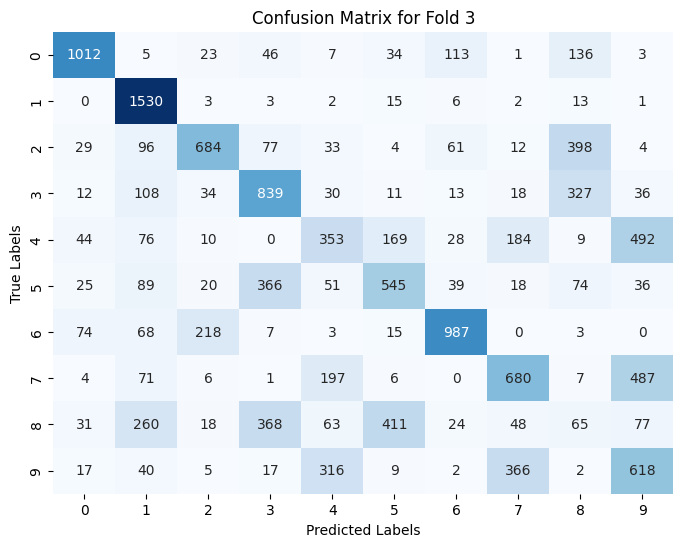

[Fold 4] train acc=0.5241 | test acc=0.5271


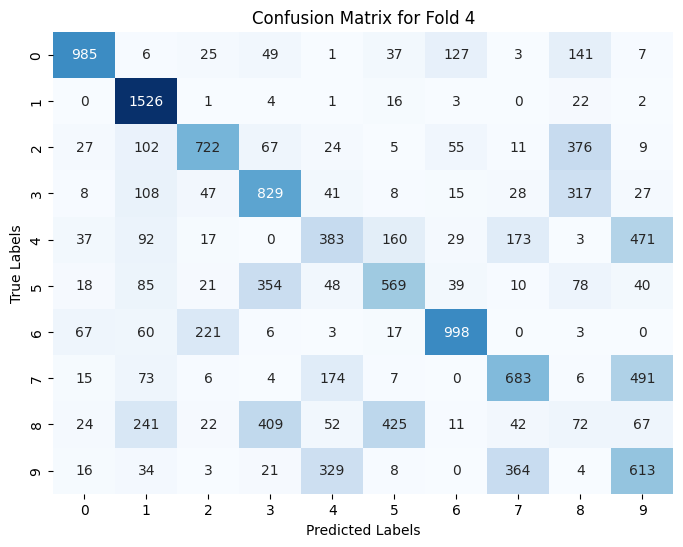

[Fold 5] train acc=0.5240 | test acc=0.5261


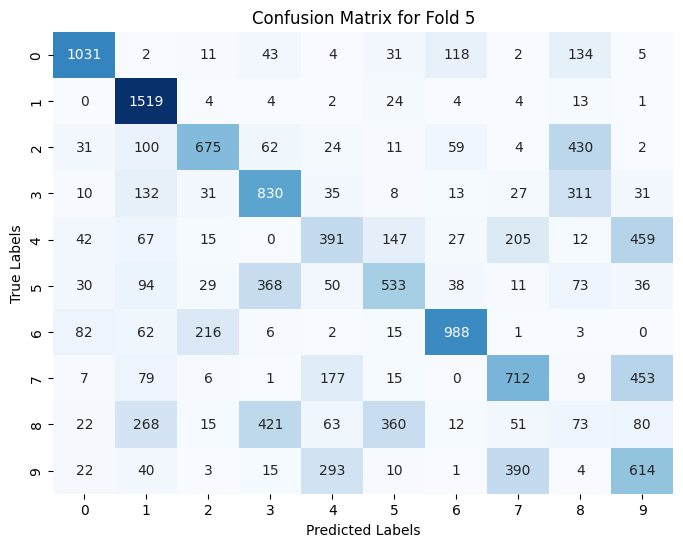

—— Cosine summary ——
Mean train accuracy: 0.5174 ± 0.0138
Mean test  accuracy: 0.5180 ± 0.0122
Cosine distance metric completed. time: 138.33 seconds.



In [36]:
X_full, y_full = load_mnist_full()

mean = X_full.mean(axis=0)
std = X_full.std(axis=0)

# if standart deviation is zero
std[std == 0] = 1

# (Z-Score)
X_full_standardized = (X_full - mean) / std

for metric in ('euclidean', 'manhattan', 'cosine'):
    start_time = time.time()
    evaluate(X_full_standardized, y_full, distance=metric, n_splits=5)
    elapsed_time = time.time() - start_time
    print(f"{metric.capitalize()} distance metric completed. time: {elapsed_time:.2f} seconds.\n")

#PCA Analysis

Number of components that protect %90 variance: 238


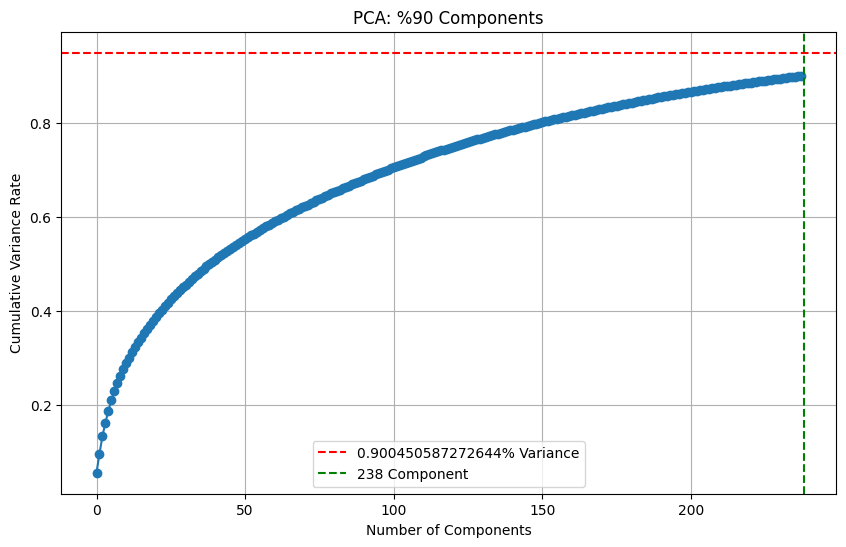

In [37]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

X_full, y_full = load_mnist_full()

mean = X_full.mean(axis=0)
std = X_full.std(axis=0)

# if standart deviation is zero
std[std == 0] = 1

#(Z-Score)
X_full_standardized = (X_full - mean) / std

# PCA: %95 Number of components to protect variance
pca = PCA(n_components=0.9, random_state=42)
X_full_pca = pca.fit_transform(X_full_standardized)

print(f"Number of components that protect %90 variance: {pca.n_components_}")

# cumulative_variance graphic
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label=f"{cumulative_variance[cumulative_variance.size - 1]}% Variance")
plt.axvline(x=pca.n_components_, color='g', linestyle='--', label=f"{pca.n_components_} Component")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Rate")
plt.title("PCA: %90 Components")
plt.legend()
plt.grid(True)
plt.show()



#Test With PCA


Evaluating with euclidean distance metric:
[Fold 1] train acc=0.4398 | test acc=0.4390


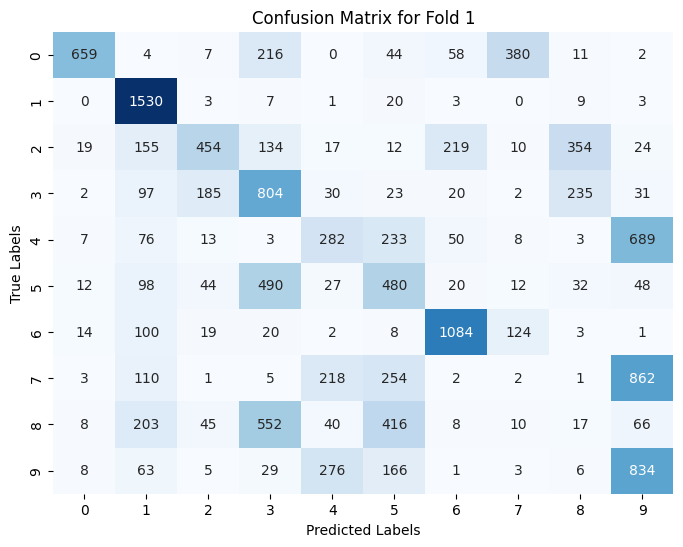

[Fold 2] train acc=0.4501 | test acc=0.4461


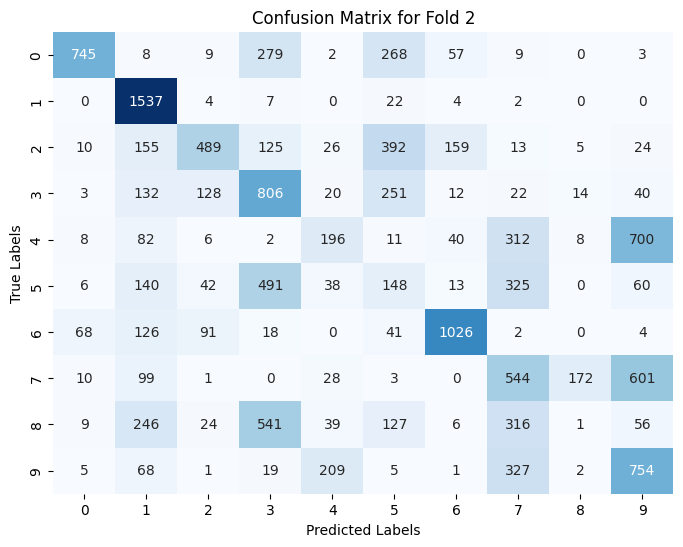

[Fold 3] train acc=0.4878 | test acc=0.4856


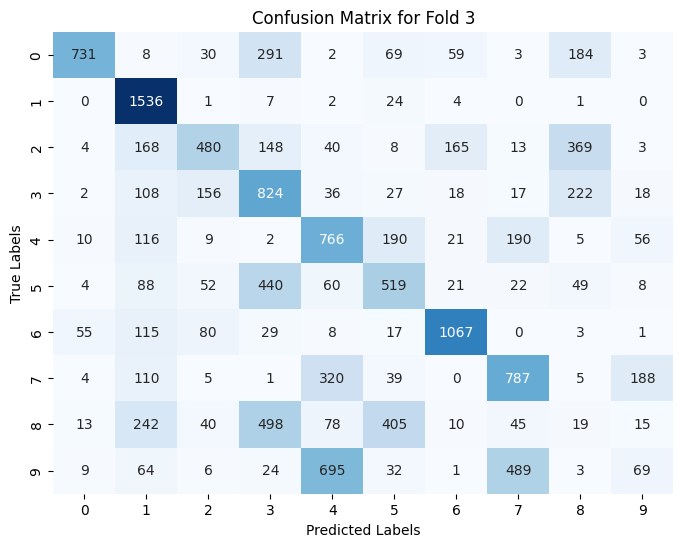

[Fold 4] train acc=0.5002 | test acc=0.5041


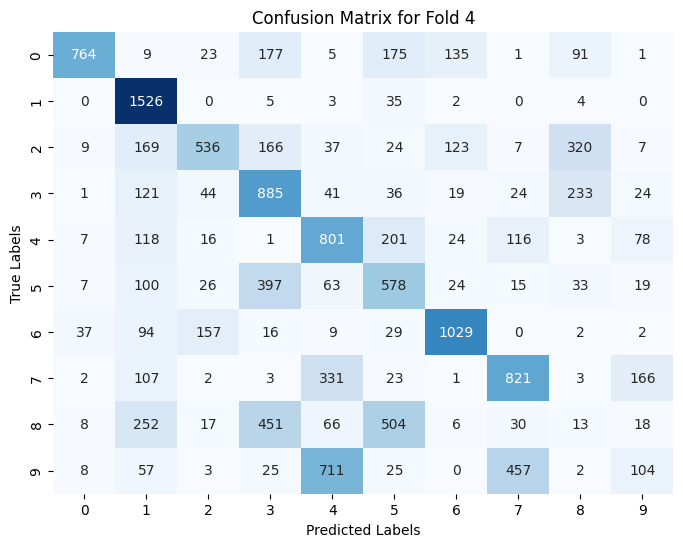

[Fold 5] train acc=0.5069 | test acc=0.5004


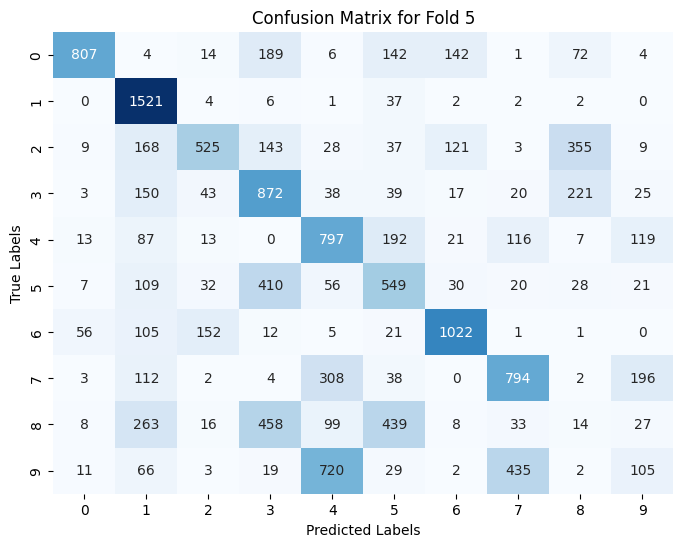

—— Euclidean summary ——
Mean train accuracy: 0.4770 ± 0.0270
Mean test  accuracy: 0.4750 ± 0.0273
Euclidean distance metric completed. Time: 229.62 seconds.


Evaluating with manhattan distance metric:
[Fold 1] train acc=0.4630 | test acc=0.4661


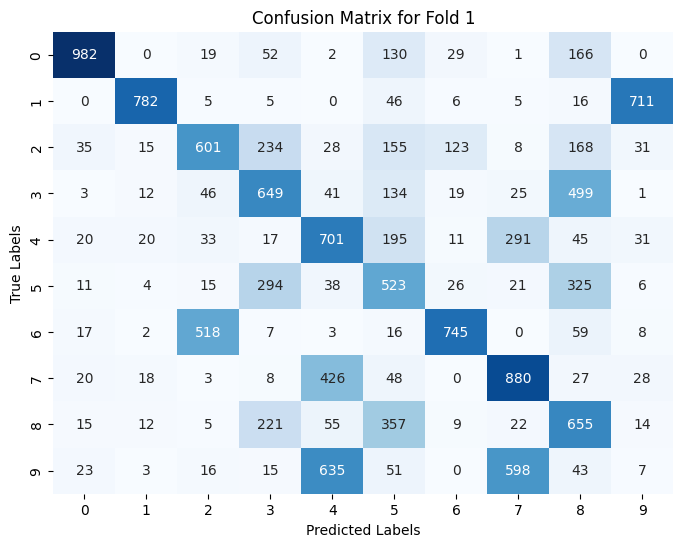

[Fold 2] train acc=0.4080 | test acc=0.4120


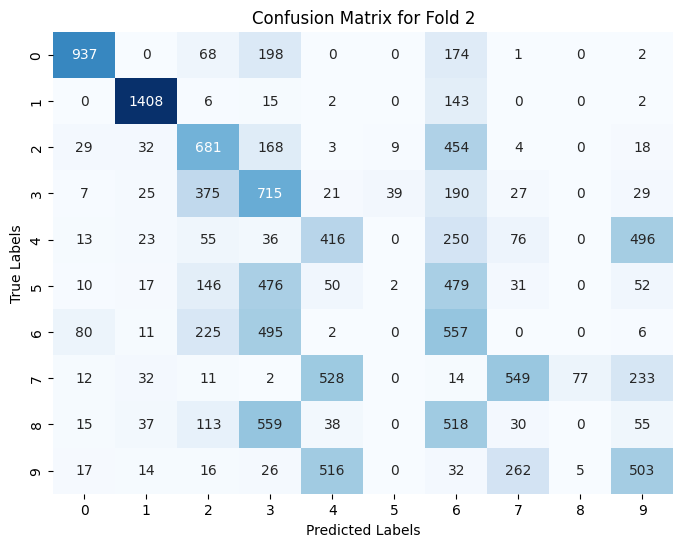

[Fold 3] train acc=0.4314 | test acc=0.4258


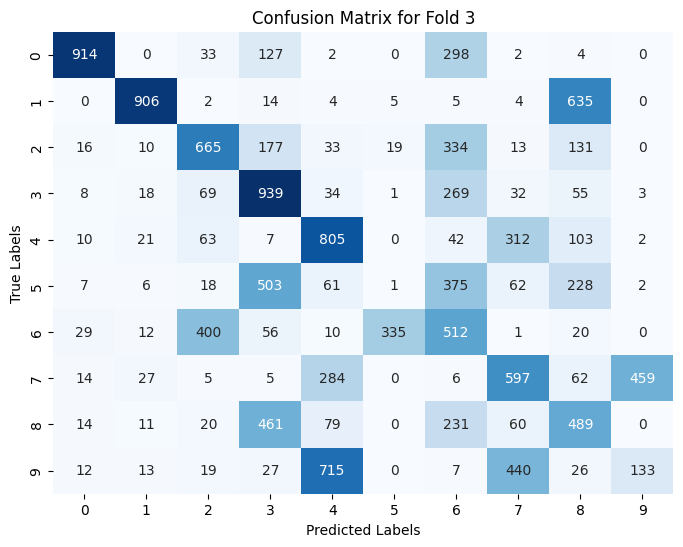

[Fold 4] train acc=0.4786 | test acc=0.4788


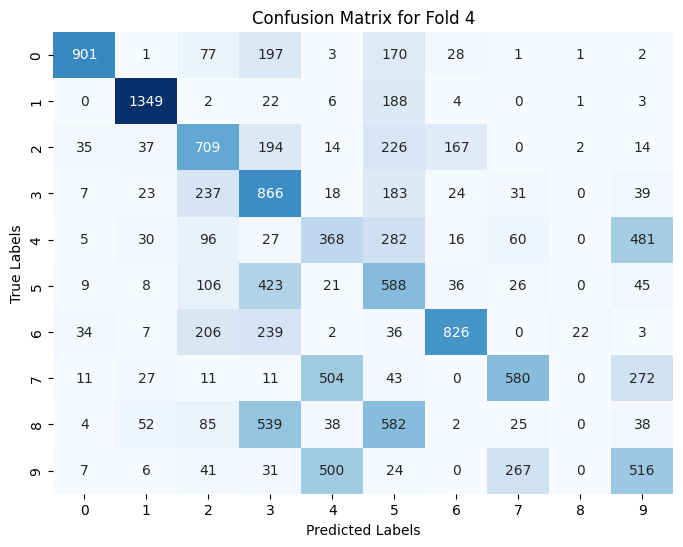

[Fold 5] train acc=0.4514 | test acc=0.4424


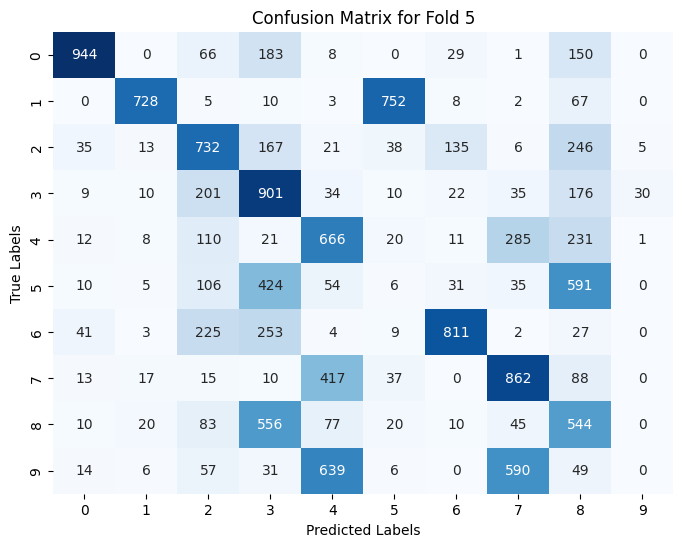

—— Manhattan summary ——
Mean train accuracy: 0.4465 ± 0.0246
Mean test  accuracy: 0.4450 ± 0.0247
Manhattan distance metric completed. Time: 418.07 seconds.


Evaluating with cosine distance metric:
[Fold 1] train acc=0.4899 | test acc=0.4942


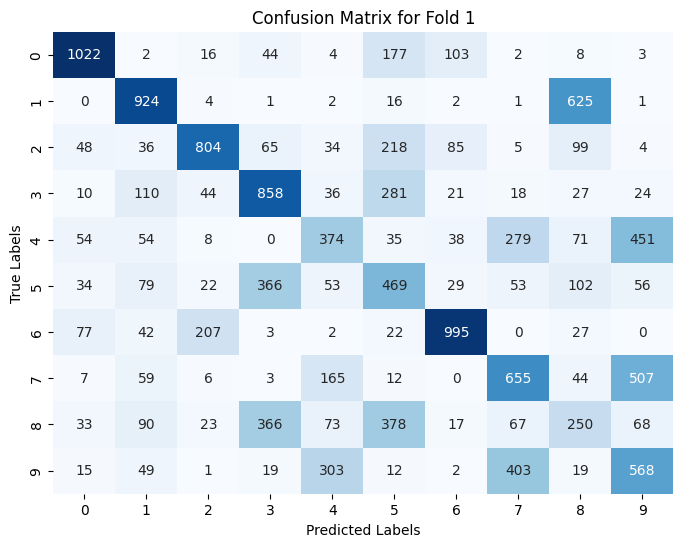

[Fold 2] train acc=0.5250 | test acc=0.5211


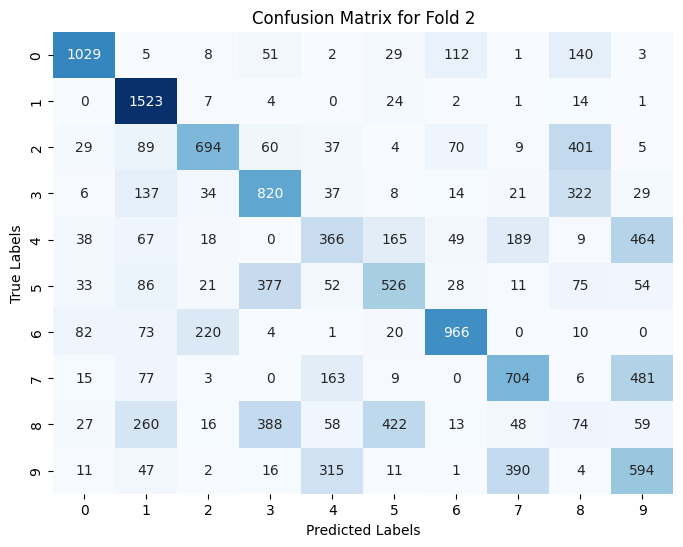

[Fold 3] train acc=0.5244 | test acc=0.5224


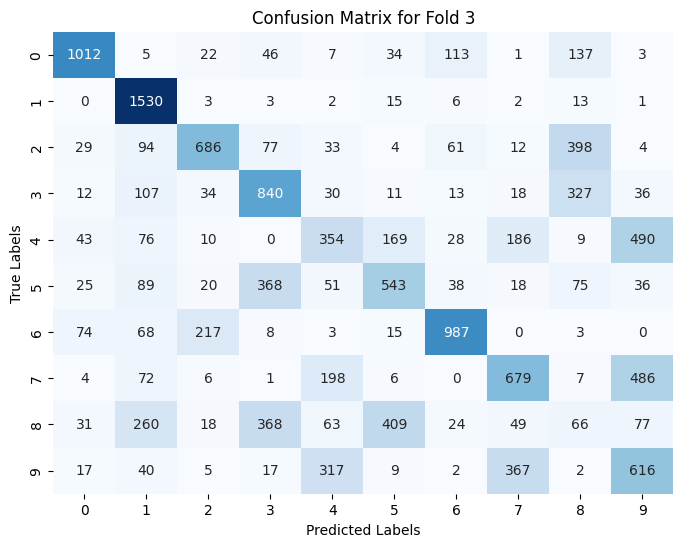

[Fold 4] train acc=0.5243 | test acc=0.5273


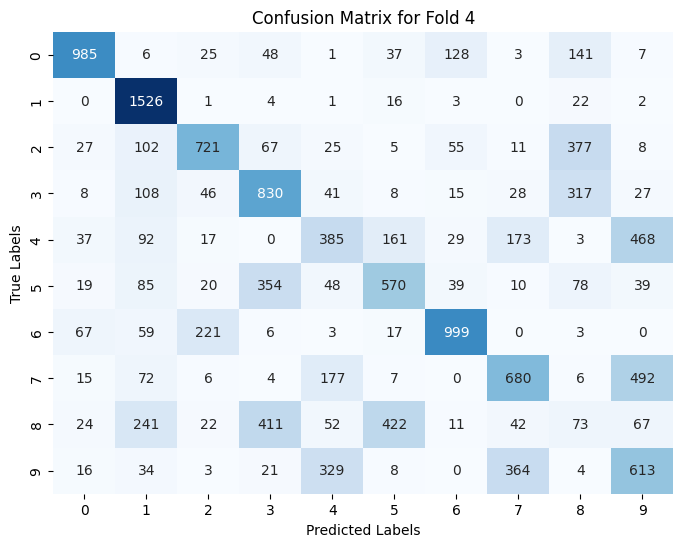

[Fold 5] train acc=0.5241 | test acc=0.5259


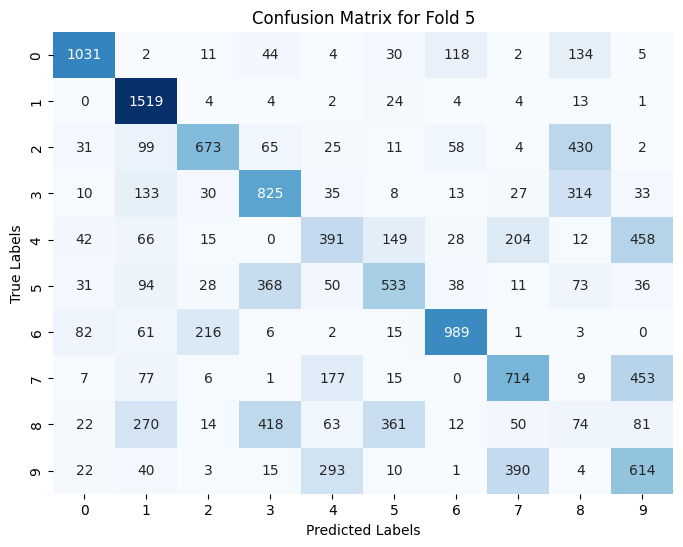

—— Cosine summary ——
Mean train accuracy: 0.5176 ± 0.0139
Mean test  accuracy: 0.5182 ± 0.0122
Cosine distance metric completed. Time: 59.31 seconds.



In [38]:
for metric in ('euclidean', 'manhattan', 'cosine'):
    start_time = time.time()
    print(f"\nEvaluating with {metric} distance metric:")
    evaluate(X_full_pca, y_full, distance=metric, n_splits=5)
    elapsed_time = time.time() - start_time
    print(f"{metric.capitalize()} distance metric completed. Time: {elapsed_time:.2f} seconds.\n")


#Conclusion

The performance of the K-means model using three different distance metrics (Euclidean, Manhattan, and Cosine) on the dataset without PCA revealed that each metric performed differently depending on the data structure and class characteristics. Euclidean (L2) distance consistently achieved the highest accuracy, around 50%. This metric provided stable results in high-dimensional data because it considers all features equally. However, it struggled to distinguish similar classes (such as 4, 5, and 7), where feature similarity caused frequent misclassifications. When PCA was applied, reducing the data from 784 to 238 features while retaining 90% of the variance, Euclidean's accuracy remained almost unchanged. This stability indicates that Euclidean distance effectively captures the essential structure of the data, even with dimensionality reduction.

Manhattan (L1) distance showed the lowest performance, with accuracy ranging between 46% and 52%. As it is based on absolute differences between feature values, it is highly sensitive in high-dimensional data, where each feature can significantly impact the distance calculation. Frequent misclassifications occurred among similar classes (4, 5, 7, 8, and 9). Surprisingly, after applying PCA, Manhattan's accuracy dropped by around 4%. This decline can be attributed to PCA removing some features that were crucial for Manhattan distance, which depends on the absolute values of individual features. Since Manhattan considers the contribution of each feature independently, losing critical features through PCA weakened its performance.

Cosine distance achieved an accuracy range between 48% and 52%, with high performance on certain classes (especially 0, 1, and 6). Cosine measures the angular similarity between vectors, making it effective in distinguishing classes with distinct directions. When PCA was applied, Cosine distance showed almost no change in performance. This stability is due to the fact that PCA preserves the directional information of the data, which is crucial for Cosine distance. In other words, even with reduced dimensions, the directional relationships between data points remained intact.

Overall, reducing the data to 238 features using PCA had minimal impact on Euclidean and Cosine distances, but led to a significant decrease in Manhattan's accuracy. While Euclidean and Cosine rely on the general structure and direction of the data, making them resilient to feature reduction, Manhattan is highly sensitive to the absolute differences between features. The results highlight the importance of selecting the appropriate distance metric based on the data structure and feature importance.